In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_accuracy_data(folder_path, downstream_task='lc', is_inference=False, test_metric='acc'):
    # Initialize a list to store data
    data = []
    
    if is_inference:
        json_file = 'artifacts_inference.json'
        metric = 'inference_metrics'
    else:
        json_file = 'artifacts.json'
        metric = 'test_metrics'

    # Walk through the directory structure
    for model_folder in os.listdir(folder_path):
        model_path = os.path.join(folder_path, model_folder, downstream_task)
        if os.path.isdir(model_path):  # Ensure it is a directory
            for n_shot_folder in os.listdir(model_path):
                n_shot_path = os.path.join(model_path, n_shot_folder)
                if os.path.isdir(n_shot_path):  # Ensure it is a directory
                    json_file_path = os.path.join(n_shot_path, json_file)
                    if os.path.isfile(json_file_path):  # Check if the JSON file exists
                        with open(json_file_path, 'r') as file:
                            data_json = json.load(file)
                            # Extract the accuracy
                            accuracy = data_json[metric][test_metric]
                            
                            # Extract 'Frozen' status from n_shot_folder
                            pattern = rf"_(frozen|unfrozen)_{downstream_task}_reduce_on_plateau"
                            match_frozen = re.search(pattern, n_shot_folder)
                            if match_frozen:
                                frozen_status = match_frozen.group(1)
                            else:
                                frozen_status = None
                            
                            # Extract n-shot number from n_shot_folder
                            match_nshot = re.search(r'_(\d+)$', n_shot_folder)
                            if match_nshot:
                                n_shot_number = int(match_nshot.group(1))
                            else:
                                n_shot_number = None
                            
                            # Append the data
                            data.append({
                                'Model': model_folder,
                                'N-Shot': n_shot_folder,
                                'N-Shot-Number': n_shot_number,
                                'Frozen': frozen_status,
                                'Accuracy': accuracy
                            })

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

    # Clean up the model names
    # Directly modifying the DataFrame without chaining
    df['Model'] = df['Model'].str.replace('^phi2_', '', regex=True)
    df['Model'] = df['Model'].str.replace('^s2_on_phi2_', '', regex=True)
    model_mapping = {
        'phileo_precursor': 'PhilEO Precursor (U-Net)',
        'GeoAware': 'GeoAware (U-Net)',
        'vit_cnn_gc': 'ViT-CNN'
    }
    df['Model'] = df['Model'].map(model_mapping).fillna(df['Model'])
    
    # Now, split the DataFrame into two based on 'Frozen' status
    frozen_df = df[df['Frozen'] == 'frozen']
    unfrozen_df = df[df['Frozen'] == 'unfrozen']
    
    # For each DataFrame, create pivot tables
    frozen_pivot_df = frozen_df.pivot_table(
        index='Model', columns='N-Shot-Number', values='Accuracy'
    )
    unfrozen_pivot_df = unfrozen_df.pivot_table(
        index='Model', columns='N-Shot-Number', values='Accuracy'
    )
    
    # Order the DataFrame columns by converting to integers
    frozen_pivot_df = frozen_pivot_df[sorted(frozen_pivot_df.columns)]
    unfrozen_pivot_df = unfrozen_pivot_df[sorted(unfrozen_pivot_df.columns)]
    
    # Remove the column name
    frozen_pivot_df.columns.name = None
    unfrozen_pivot_df.columns.name = None

    return frozen_pivot_df, unfrozen_pivot_df


In [3]:
folder_path = '/home/ccollado/2_phileo_fm/models/nshot_s2'
acc_s2_frozen, acc_s2_unfrozen = extract_accuracy_data(folder_path)
acc_s2_frozen

,50,100,500,1000,5000
Model,,,,,
GeoAware (U-Net),0.585277,0.642667,0.685492,0.707438,NaN
PhilEO Precursor (U-Net),0.521808,0.544513,0.583474,0.616237,NaN
SatMAE,0.469704,0.503562,0.581833,0.615618,0.690709
ViT-CNN,0.486391,0.505166,0.608366,0.620121,NaN
prithvi,0.491472,0.510176,0.558142,0.597219,0.650636


In [4]:
folder_path = '/home/ccollado/2_phileo_fm/models/nshot_phi2'
acc_phi2_frozen, acc_phi2_unfrozen = extract_accuracy_data(folder_path)
acc_phi2_frozen

,50,100,500,1000,5000
Model,,,,,
GeoAware (U-Net),0.560920,0.600231,0.643993,0.663634,0.696250
PhilEO Precursor (U-Net),0.489892,0.531623,0.565437,0.591997,0.648518
SatMAE,0.462417,0.510493,0.569732,0.595585,0.671844
ViT-CNN,0.487623,0.525620,0.586548,0.604831,NaN
prithvi,0.538733,0.567370,0.626926,0.647627,NaN


In [5]:
folder_path = '/home/ccollado/2_phileo_fm/models/nshot_s2_on_phi2'
acc_s2_on_phi2_frozen, acc_s2_on_phi2_unfrozen = extract_accuracy_data(folder_path, is_inference=True)
acc_s2_on_phi2_frozen

,50,100,500,1000,5000
Model,,,,,
GeoAware (U-Net),0.309989,0.281965,0.257827,0.221628,NaN
PhilEO Precursor (U-Net),0.152497,0.127140,0.275991,0.292075,NaN
SatMAE,0.380571,0.387944,0.174258,0.127268,0.29550
ViT-CNN,0.121003,0.116927,0.220604,0.213656,NaN
prithvi,0.283324,0.287607,0.248220,0.241012,0.11724


In [6]:
acc_phi2_unfrozen

,50,100,500,1000,5000
Model,,,,,
GeoAware (U-Net),0.566153,0.593194,0.660106,0.690754,0.708476
PhilEO Precursor (U-Net),0.544533,0.557077,0.595464,0.606022,NaN
SatMAE,0.523153,0.543541,0.608044,0.644507,NaN


<Figure size 3000x800 with 0 Axes>

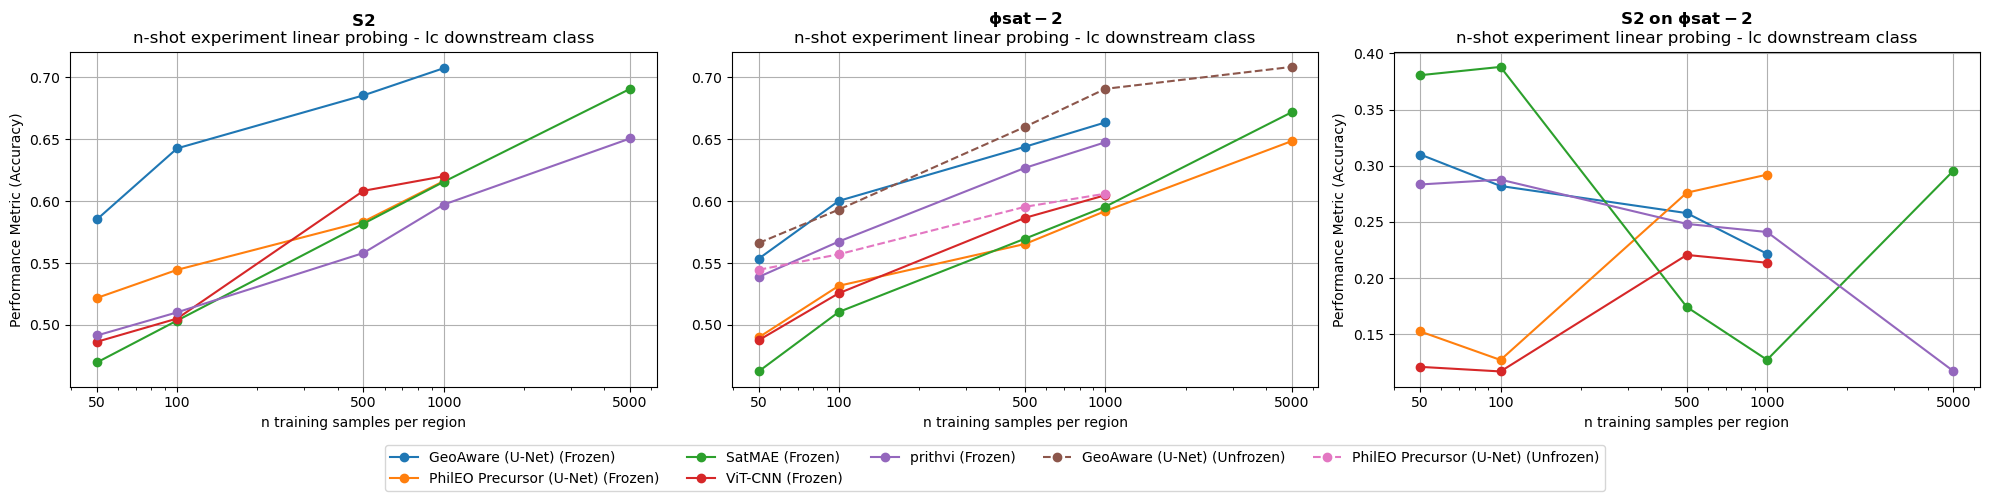

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Increase the total figure size to accommodate three subplots
plt.figure(figsize=(30, 8))

# Create subplots with a shared y-axis between the first two, and separate for the third
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax1, ax2, ax3 = axs[0], axs[1], axs[2]

# Manually share y-axis between the first two plots
ax2.sharey(ax1)

# Collect labels for the legend
handles, labels = [], []

# Plotting for acc_s2_frozen and acc_s2_unfrozen on the left
for df, style in zip([acc_s2_frozen, acc_s2_unfrozen], ['-', '--']):
    for model in df.index:
        ax1.plot(df.columns.astype(int), df.loc[model], marker='o', linestyle=style, label=f"{model} {'Frozen' if 'frozen' in df else 'Unfrozen'}")

# Set logarithmic scale and custom ticks for ax1
ax1.set_xscale('log')
ax1.set_xticks([50, 100, 500, 1000, 5000])
ax1.get_xaxis().set_major_formatter(ScalarFormatter())
ax1.set_xlabel("n training samples per region")
ax1.set_ylabel("Performance Metric (Accuracy)")
ax1.set_title(r"$\bf{S2}$" + "\n" + "n-shot experiment linear probing - lc downstream class")
ax1.grid(True)

# Plotting for acc_phi2_frozen and acc_phi2_unfrozen in the middle
for df, label_suffix in zip([acc_phi2_frozen, acc_phi2_unfrozen], ['Frozen', 'Unfrozen']):
    for model in df.index:
        line, = ax2.plot(df.columns.astype(int), df.loc[model], marker='o', linestyle='-' if label_suffix == 'Frozen' else '--', label=f"{model} ({label_suffix})")
        handles.append(line)
        labels.append(f"{model} ({label_suffix})")


# Set logarithmic scale and custom ticks for ax2
ax2.set_xscale('log')
ax2.set_xticks([50, 100, 500, 1000, 5000])
ax2.get_xaxis().set_major_formatter(ScalarFormatter())
ax2.set_xlabel("n training samples per region")
ax2.set_title(r"$\bf{\phi sat-2}$" + "\n" + "n-shot experiment linear probing - lc downstream class")
ax2.grid(True)

# Plotting for acc_s2_on_phi2_frozen in the right, separate y-axis handling
# Check if the dataframe is empty
if not acc_s2_on_phi2_frozen.empty:
    for model in acc_s2_on_phi2_frozen.index:
        ax3.plot(acc_s2_on_phi2_frozen.columns.astype(int), acc_s2_on_phi2_frozen.loc[model], marker='o', label=model)

# Set logarithmic scale and custom ticks for ax3
ax3.set_xscale('log')
ax3.set_xticks([50, 100, 500, 1000, 5000])
ax3.get_xaxis().set_major_formatter(ScalarFormatter())
ax3.set_xlabel("n training samples per region")
ax3.set_ylabel("Performance Metric (Accuracy)")
ax3.set_title(r"$\bf{S2}$ $\bf{on}$ $\bf{\phi sat-2}$" + "\n" + "n-shot experiment linear probing - lc downstream class")
ax3.grid(True)

# Create a single shared legend from the handles and labels collected from the first plot
fig.legend(handles, labels, loc="lower center", ncol=5)

# Adjust layout to fit legend and ensure tight layout
fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the rectangle to accommodate the bottom legend

plt.show()


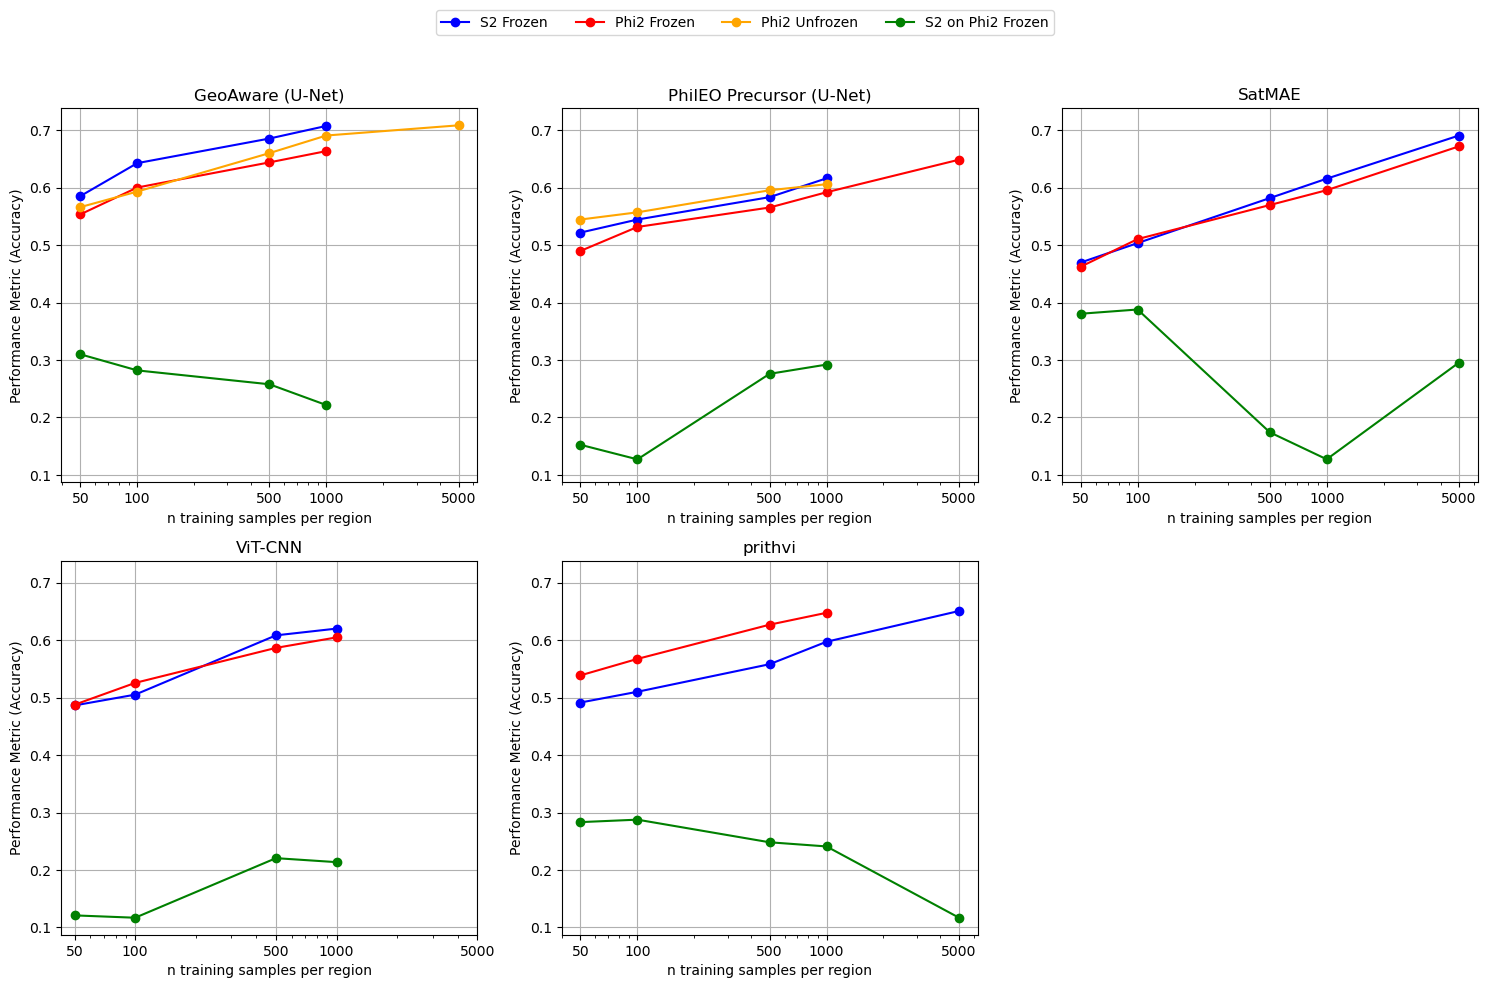

In [8]:
# Collect all unique models
all_models = set(acc_s2_frozen.index.tolist() + acc_s2_unfrozen.index.tolist() +
                 acc_phi2_frozen.index.tolist() + acc_phi2_unfrozen.index.tolist() +
                 acc_s2_on_phi2_frozen.index.tolist() + acc_s2_on_phi2_unfrozen.index.tolist())

# Calculate the number of rows needed for a 3-column layout
n_models = len(all_models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols  # Round up to ensure all models fit

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=False, sharey=True)
axes = axes.flatten()  # Flatten the array to make iteration easier

# Plot data for each model in its respective subplot
for ax, model in zip(axes, sorted(all_models)):
    x_values = set()

    # Frozen and unfrozen for S2
    for df, label, color in [(acc_s2_frozen, 'S2 Frozen', 'blue'), (acc_s2_unfrozen, 'S2 Unfrozen', 'cyan')]:
        if model in df.index:
            x = df.columns.astype(int)
            y = df.loc[model]
            ax.plot(x, y, marker='o', label=label, color=color)
            x_values.update(x)
    
    # Frozen and unfrozen for Phi2
    for df, label, color in [(acc_phi2_frozen, 'Phi2 Frozen', 'red'), (acc_phi2_unfrozen, 'Phi2 Unfrozen', 'orange')]:
        if model in df.index:
            x = df.columns.astype(int)
            y = df.loc[model]
            ax.plot(x, y, marker='o', label=label, color=color)
            x_values.update(x)

    # Frozen and unfrozen for S2 on Phi2 (skip unfrozen if empty)
    for df, label, color in [(acc_s2_on_phi2_frozen, 'S2 on Phi2 Frozen', 'green')]:
        if model in df.index:
            x = df.columns.astype(int)
            y = df.loc[model]
            ax.plot(x, y, marker='o', label=label, color=color)
            x_values.update(x)
        
    if not x_values:
        ax.axis('off')
        continue
    
    ax.set_xscale('log')
    ax.set_title(f"{model}")
    ax.set_xlabel("n training samples per region")
    ax.set_ylabel("Performance Metric (Accuracy)")
    ax.grid(True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    ax.set_xticks(sorted(x_values))
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# Collect handles and labels from all axes
handles_labels = {}
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        handles_labels[label] = handle  # Use label as key to avoid duplicates
handles = list(handles_labels.values())
labels = list(handles_labels.keys())

# Create a legend and place it centrally above all subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(handles))

# Disable unused axes if there are any
for ax in axes[n_models:]:
    ax.axis('off')

# Adjust layout to not overlap and show all titles and x-labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### GeoAware
- Pretrained on PhilEO globe dataset
- This explains that achieves better performance on PhilEO data

### PhilEO Precursor
- Pretrained on a subset of MajorTOM (TinyTOM)
- Similar performance in S2 and phi2 data - could be because dataset is more diverse (only pretrained on S2 data tho)

### SatMAE
- Pretrained on different fMoW datsets: RGB, S2 - also temporal/non-temporal, multispectral
- Similar performance in S2 and phi2 data - could be because dataset is more diverse

### ViT-CNN
- Pretrained on ??????????
- Similar performance in S2 and phi2 data - could be because dataset is more diverse

### Prithvi
- Pretrained on NASA's HLS V2 L30 product - Harmonized Landsat Sentinel-2 Dataset
- Better performance on phi2 - it could be because S2 patches were resized to 30m, while phi2 are kept to 10m, so the patches of phi2 contain more information in each patch 


# Building

In [9]:
folder_path = '/home/ccollado/2_phileo_fm/models/nshot_phi2'
acc_phi2_building_frozen, acc_phi2_building_unfrozen = extract_accuracy_data(folder_path, downstream_task='building', test_metric='mse')
acc_phi2_building_frozen

,50,100,500,1000
Model,,,,
GeoAware (U-Net),0.055157,0.032342,0.002544,0.001975


In [10]:
folder_path = '/home/ccollado/2_phileo_fm/models/l1a_nshot_phi2'
acc_l1a_building_frozen, acc_l1a_building_unfrozen = extract_accuracy_data(folder_path, downstream_task='building', test_metric='mse')
acc_l1a_building_frozen

,50,100,500,1000
Model,,,,
GeoAware (U-Net),0.058322,0.003842,0.002471,0.001988


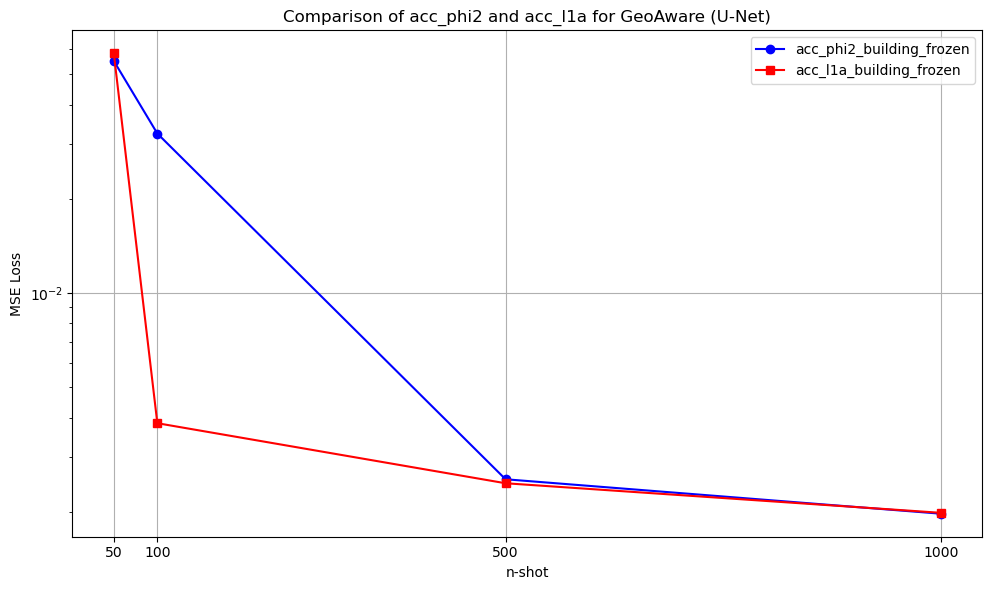

In [12]:
# Step 2: Prepare the data for plotting
# Extract the x-axis values (assuming they are the same for both DataFrames)
x_values = acc_phi2_building_frozen.columns.astype(int)

# Extract y-axis values
y_phi2 = acc_phi2_building_frozen.loc['GeoAware (U-Net)'].values
y_l1a = acc_l1a_building_frozen.loc['GeoAware (U-Net)'].values

# Step 3: Plotting
plt.figure(figsize=(10, 6))

plt.plot(x_values, y_phi2, marker='o', linestyle='-', color='blue', label='acc_phi2_building_frozen')
plt.plot(x_values, y_l1a, marker='s', linestyle='-', color='red', label='acc_l1a_building_frozen')

# Step 4: Customize the plot
plt.title('Comparison of acc_phi2 and acc_l1a for GeoAware (U-Net)')
plt.xlabel('n-shot')
plt.ylabel('MSE Loss')
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.show()

# Pretrain Results on Downstream Tasks

In [24]:
import os
import json
import pandas as pd

def extract_accuracy(exp1_folder):
    """
    Extracts accuracy values from artifacts.json files within subdirectories
    named with 'nshot' values at the end.

    Args:
        exp1_folder (str): Path to the experiment folder containing subdirectories.

    Returns:
        pd.DataFrame: DataFrame with 'nshot' as the index and 'Accuracy' as the column.
    """
    data = {}
    
    for dir_name in os.listdir(exp1_folder):
        dir_path = os.path.join(exp1_folder, dir_name)
        artifacts_path = os.path.join(dir_path, "artifacts.json")
        
        # Extract nshot from folder name (assuming it's the last number in the name)
        try:
            nshot = int(dir_name.split('_')[-1])
        except ValueError:
            print(f"Could not extract nshot from directory name: {dir_name}")
            continue
        
        # Open artifacts.json and extract accuracy
        try:
            with open(artifacts_path, 'r') as f:
                artifacts = json.load(f)
                acc = artifacts["test_metrics"]["acc"]
                data[nshot] = acc
        except (FileNotFoundError, KeyError, json.JSONDecodeError) as e:
            print(f"Error processing {artifacts_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Accuracy'])
    df.index.name = 'nshot'
    df = df.sort_index()
    
    return df

# Example Usage
exp1_folder = '/home/ccollado/2_phileo_fm/models/pretrained/phi2_GeoAware/exp1/lc'
exp2_folder = '/home/ccollado/2_phileo_fm/models/pretrained/phi2_GeoAware/exp2/lc'

exp1 = extract_accuracy(exp1_folder)
exp2 = extract_accuracy(exp2_folder)

In [34]:
acc_phi2_frozen_pretrain = acc_phi2_frozen.copy()
acc_phi2_frozen_pretrain.loc['Pretrained exp 1'] = exp1['Accuracy']
acc_phi2_frozen_pretrain.loc['Pretrained exp 2'] = exp2['Accuracy']
acc_phi2_frozen_pretrain

,50,100,500,1000,5000
Model,,,,,
GeoAware (U-Net),0.560920,0.600231,0.643993,0.663634,0.696250
PhilEO Precursor (U-Net),0.489892,0.531623,0.565437,0.591997,0.648518
SatMAE,0.462417,0.510493,0.569732,0.595585,0.671844
ViT-CNN,0.487623,0.525620,0.586548,0.604831,NaN
prithvi,0.538733,0.567370,0.626926,0.647627,NaN
Pretrained exp 1,0.500267,0.508167,0.539533,0.560968,0.570174
Pretrained exp 2,0.517910,0.530257,0.559040,0.582980,0.616023


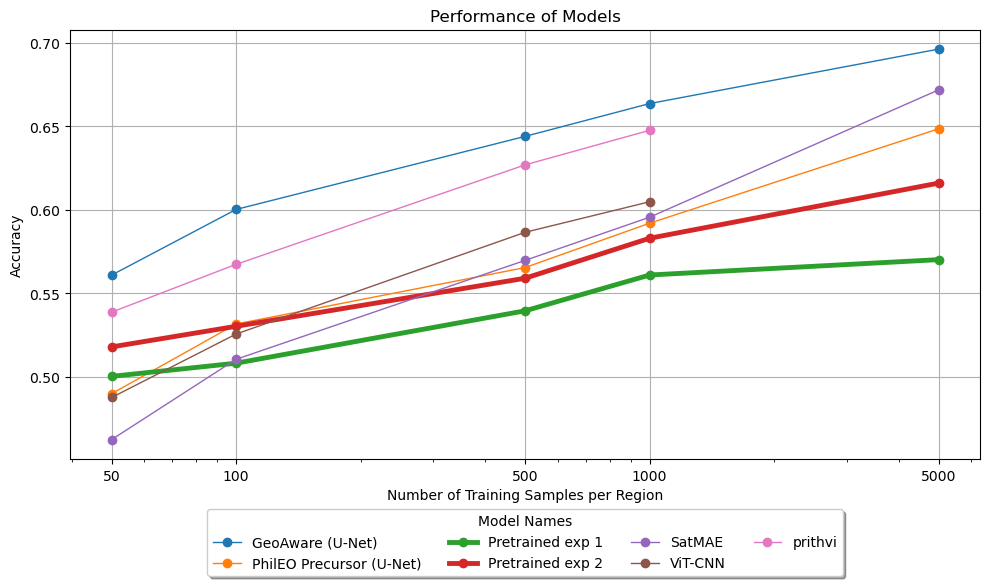

In [41]:
# Collect all unique models from the DataFrame
all_models = acc_phi2_frozen_pretrain.index.tolist()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Plot data for each model
for model in sorted(all_models):
    x = acc_phi2_frozen_pretrain.columns.astype(int)  # Assuming the columns represent training samples
    y = acc_phi2_frozen_pretrain.loc[model]
    line_width = 3.5 if "exp" in model else 1.0  # Thicker line if "exp" in the model name
    ax.plot(x, y, marker='o', label=model, linewidth=line_width)

# Set the scale of the x-axis and labels for the xticks
ax.set_xscale('log')
ax.set_xticks(x)
ax.set_xticklabels(x)

# Add plot title and labels
ax.set_title("Performance of Models")
ax.set_xlabel("Number of Training Samples per Region")
ax.set_ylabel("Accuracy")

# Enable grid
ax.grid(True)

# Place and format the legend
ax.legend(title="Model Names", loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()
